# Adversarial Attack 

- develop a model for mnist dataset using fastai
- attack the model using foolbox (black box attack)
- check the density & coverage metrics

In [1]:
# dependencies
import os 
os.environ["GIT_PYTHON_REFRESH"] = "quiet" 
#!module load git
import foolbox as fb
import torch
import eagerpy as ep
from foolbox import PyTorchModel, accuracy, samples
import numpy as np

In [2]:
import torchvision
from fastai.vision.all import *

Fix the seed generator

In [3]:
torch.manual_seed(42) 
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
np.random.seed(42)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


### Import the MNIST dataset 

In [5]:
def load_mnist():
    """Function to load the mnist
        The foolowing transform is aaplied: Normalize:(0.1307,)(0.3081,)
    
    """
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081))
    ])
    train_set = torchvision.datasets.MNIST('./files/', train=True, download=True, transform=transforms)
    test_set = torchvision.datasets.MNIST('./files/', train=False, download=True, transform=transforms)
    
    return train_set, test_set

train_set, test_set = load_mnist()

### Combine the datasets and stratify split 
- Combine train and test
- form the model_dataset[training+ test] and validation set

In [6]:
from torch.utils.data import ConcatDataset
from sklearn.model_selection import train_test_split

def create_dataset(train_set, test_set, vali_split, test_split):
    """Function to split the dataset and form the training, test and validation datasets
        
        Parameters
        ----------------------
        train_set: torch.utils.mnist.dataset
        test_set: torch.utils.mnist.dataset
        vali_split: the size for the validation set 
        test_split: the size of the test set
        
        Return
        ----------------------
        X_trainset: list, size: train_size, 1, 28, 28
        X_testset: list, size: test_size, 1, 28, 28
        X_validation: list, size: vali_size, 1, 28, 28
        y_trainset: list, size: train_size
        y_testset: list, size: test_size
        y_valiset: list, size: vali_size
        
    """
    # combine the datasets
    dataset = ConcatDataset([train_set, test_set])
    X=[]; Y=[];
    for i in range(len(dataset)):
        x, y = dataset[i]
        X.append(x.numpy())  #.detach().cpu().numpy())
        Y.append(y)
    
    # split the dataset into train and validation set
    X_model, X_validation, y_model, y_validation = train_test_split(X, Y, test_size=vali_split, random_state=42, stratify=np.array(Y))

    print("X_validation_set size: ", np.array(X_validation).shape)
    print("Y_validation_set size: ", len(y_validation))
    
    # form the model_dataset for the metrics
    # model_dataset = ConcatData
    
    # split the X_train into training set & test set
    X_trainset, X_testset, y_trainset, y_testset = train_test_split(X_model, y_model, test_size=test_split, random_state=42)
    print("X_train_set size: ", np.array(X_trainset).shape)
    print("Y_train_set size: ", len(y_trainset))
    print("X_test_set size: ", np.array(X_testset).shape)
    print("Y_test_set size: ", len(y_testset))
    
    #X = np.array(X); Y = np.array(Y)
    
    return X_trainset, X_testset, X_validation, y_trainset, y_testset, y_validation

X_trainset, X_testset, X_validation, y_trainset, y_testset, y_validation = create_dataset(train_set, test_set, 0.03, 0.2)

X_validation_set size:  (2100, 1, 28, 28)
Y_validation_set size:  2100
X_train_set size:  (54320, 1, 28, 28)
Y_train_set size:  54320
X_test_set size:  (13580, 1, 28, 28)
Y_test_set size:  13580


### Convert the datasets to Torch.TensorDataset

In [7]:
def convert_tensor(X_trainset, X_testset, X_validation, y_trainset, y_testset, y_validation):
    """
    Function to convert the split datasets into torch Tensor dataset
    
    Parameters
    ----------------------
    X_trainset: list, size: train_size, 1, 28, 28
    X_testset: list, size: test_size, 1, 28, 28
    X_validation: list, size: vali_size, 1, 28, 28
    y_trainset: list, size: train_size
    y_testset: list, size: test_size
    y_valiset: list, size: vali_size
    
    Return
    -------------------
    train_set: TensorDataset, consists of training images and labels
    test_set: TensorDataset, consists of test images and labels
    validation_set: TensorDataset, consists of validation images and labels
    
    # for the adversarial attack
    model_dataset_images: Tensor, size: (training + test) size, only the images
    model_dataset_images: Tensor, size: (training + test) size, only the labels
    """
    X_trainset = torch.Tensor(X_trainset); 
    y_trainset = torch.Tensor(y_trainset).type(torch.LongTensor) #dtype = torch.long);
    X_testset = torch.Tensor(X_testset); 
    y_testset = torch.Tensor(y_testset).type(torch.LongTensor);
    X_validation = torch.Tensor(X_validation); 
    y_validation = torch.Tensor(y_validation).type(torch.LongTensor)
    # y - label should be longTensor for fastai training
    
    # form model_dataset
    model_dataset_images = torch.vstack((X_trainset, X_testset))
    model_dataset_labels = torch.cat((y_trainset, y_testset))
    
    # form the Tensor dataset
    train_set = torch.utils.data.TensorDataset(X_trainset, y_trainset)
    test_set = torch.utils.data.TensorDataset(X_testset, y_testset)
    validation_set = torch.utils.data.TensorDataset(X_validation, y_validation)
    
    return train_set, test_set, validation_set, model_dataset_images, model_dataset_labels

train_set, test_set, validation_set, model_images, model_labels = convert_tensor(X_trainset, X_testset, X_validation, y_trainset, y_testset, y_validation)

In [41]:
torch.save(model_images, 'model_dataset_images.pt')
torch.save(model_labels, 'model_dataset_labels.pt')

In [ ]:
torch.save()

### The Dataloader for the CNN models

In [8]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1000, shuffle=True)

### Define the CNN model

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class CNet(nn.Module):
    def __init__(self):
        super(CNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), 2)
        x = F.relu(x)
        x = self.drop(self.conv2(x))
        x = F.relu(F.max_pool2d(x, 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
        

In [10]:
class NewNet(nn.Module):
    def __init__(self):
        super(NewNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(800, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.drop(F.max_pool2d(x, 2))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 800)
        x = self.drop(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

### Fastai classifier
- Fastai takes the available device by default

In [11]:
data = DataLoaders(train_loader, test_loader)
learn = Learner(data, NewNet(), loss_func=F.nll_loss, opt_func=Adam, metrics=accuracy)

- Initial fit for the model

In [41]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.172277,0.111684,0.965096,00:06
1,0.095120,0.060756,0.980192,00:03
2,0.067478,0.049296,0.983947,00:03


- Unfreeze and check the optimal learning rate

SuggestedLRs(valley=tensor(1.7378e-05))

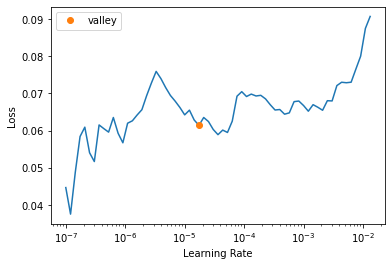

In [42]:
learn.unfreeze()
learn.lr_find()

- Fit the model again

In [43]:
learn.fit_one_cycle(8, lr_max=1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.061845,0.049151,0.984021,00:03
1,0.072000,0.048584,0.983873,00:03
2,0.071690,0.048445,0.983947,00:03
3,0.069793,0.048071,0.984536,00:03
4,0.066021,0.047852,0.984462,00:03
5,0.065057,0.047673,0.984462,00:03
6,0.067660,0.047517,0.984610,00:03
7,0.070133,0.047518,0.984610,00:03


In [45]:
#learn.recorder.plot_loss()

- Fine tune the model 

In [46]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.115505,0.060985,0.982401,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.070029,0.046246,0.985420,00:03
1,0.070937,0.041459,0.987187,00:03
2,0.045100,0.035249,0.988586,00:03
3,0.030003,0.033169,0.989617,00:03
4,0.037282,0.030900,0.990206,00:03


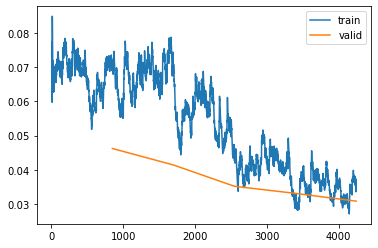

In [47]:
learn.recorder.plot_loss()

### - Save the fastai classifier
- By default it is saved in the /models folder with .pth extension

In [122]:
learn.save('./fastai_cnn_NewNet_99_splitDataset')

Path('models/fastai_cnn_NewNet_99_splitDataset.pth')

- Load the model(fastai) and save it as torch model for foolbox compatibility

In [123]:
model_new = learn.load('fastai_cnn_NewNet_99_splitDataset')
torch.save(model_new.model.state_dict(), 'fastai_cnn_NewNet_99_splitDataset_weights.pth')

### Load model for the attack

In [12]:
# load the NewNet model
MyModel = NewNet()
MyModel.load_state_dict(torch.load('chkpt_files/fastai_cnn_NewNet_99_splitDataset_weights.pth', map_location=device))
MyModel.eval()

# load the CNet model
#MyModel_1 = CNet()
#MyModel_1.load_state_dict(torch.load('fastai_cnn_weights.pth'))
#MyModel_1.eval()

NewNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (drop): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=800, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

### Create a Pytorch model for foolbox attack

In [13]:
preprocess = dict(mean=0.1307, std=0.3081)
bound = (0, 1)
original_model = fb.PyTorchModel(MyModel, bounds=bound, preprocessing=preprocess)

- Three different attacks with 100 values of epsilons

In [14]:
attack0 = fb.attacks.LinfPGD()
attack1 = fb.attacks.BoundaryAttack()
attack2 = fb.attacks.FGSM()
attack = [attack0, attack1, attack2]
epsilon = np.linspace(0.0, 1, num=20)

- Attack the ```trained network``` with model_dataset

In [15]:
images = ep.astensor(model_images.to(device))
labels = ep.astensor(model_labels.to(device))

In [17]:
def model_attack(attk, model, image, label, epsilon):
    """
    Function to perform the adv attack on the pytorch model
    
    Parameters
    --------------------
    attk: type of foolbox attack
    model: foolbox Pytorch model
    image: the images used for the attack, either as ep.tensor or torch.tensor
            size:(no_of_samples x dims)
    labels: corresponding labels for the images, either as ep.tensor or torch.tensor
            size:(no_of_samples 
    epsilon: the pertubation
    
    Return
    -------------
    clip_adv: list, the actual adversarial examples generated for the given model
                size: similar to the input images
    adv_ : boolean list, indicating whether a given image is adversarial example or not,
            True - adversarial sample
            False - not an adversarial sample
    """
    raw_adv, clip_adv, adv_ = attk(model, images, labels, epsilons=epsilon)
    
    return clip_adv, adv_


## Attack the model using 20 epsilon & ```FGSM attack```

In [18]:
adv_images, adv_info = model_attack(attack2, original_model, images[:20000,:,:,:], labels[:20000], epsilon)

#### Plot the results

Text(0.5, 1.0, 'The NewNet Model with FGSM attack')

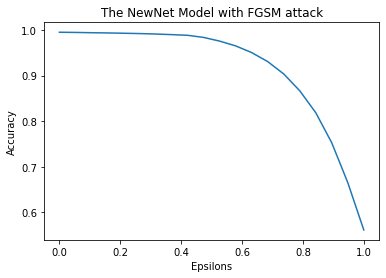

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
robust_accuracy = []
for i in range(20):
    acc = 1 - adv_info[i, :].raw.cpu().numpy().astype(np.float32).mean(axis=-1)
    robust_accuracy.append(acc)
ax.plot(epsilon, robust_accuracy)
ax.set_xlabel("Epsilons")
ax.set_ylabel("Accuracy")
ax.set_title("The NewNet Model with FGSM attack")

### Metrics

In [20]:
from n2gem.metrics import gem_build_coverage, gem_build_density

In [32]:
def model_metrics(adv_imgs, real_imgs, epi_len):
    """
    Function to compute density & coverage for the between the 
    real & adversarial samples
    
    Parameters
    ---------------
    adv_imgs: ep.tensor, the generated adversarial samples, size: no_of_images x image_dims
    real_imgs: torch.tensor, size: no_of_images x dims
    epi_len: integer, the length or number of epsilons used for the attack
    """
    density = []
    coverage = []
    
    for i in range(epi_len):
        # generated adversarial for each epsilon(convert from eagerpy --> torch and reshape)
        gen = adv_imgs[i].raw.view(adv_imgs[i].shape[0], -1)

        # density
        density.append(gem_build_density(real_imgs, real_imgs.shape[0], gen, 'indexflatl2'))

        # coverage
        coverage.append(gem_build_coverage(real_imgs, real_imgs.shape[0], gen, 'indexflatl2'))
    
    return density, coverage

### - density & coverage for

#### --> model_dataset & adversarial samples 

In [22]:
# resize the real images
real = model_images.view(model_images.shape[0], -1)[:20000, :]

# 20 values of epsilons were considered
# find the density & coverage for each vgalue of epsilons
density = []
coverage = []
for i in range(len(epsilon)):
    
    # generated adversarial for each epsilon(convert from eagerpy --> torch and reshape)
    gen = adv_images[i].raw.view(adv_images[i].shape[0], -1)
    
    # density
    density.append(gem_build_density(real, real.shape[0], gen, 'indexflatl2'))
    
    # coverage
    coverage.append(gem_build_coverage(real, real.shape[0], gen, 'indexflatl2'))

#### --> model_dataset & validation set

In [26]:
# images from the validation set
gen_validate = torch.from_numpy(np.array(X_validation).reshape(len(X_validation), -1))
gen_labels = torch.from_numpy(np.array(y_validation))
density_validate = gem_build_density(real, real.shape[0], gen_validate, 'indexflatl2')
coverage_validate = gem_build_coverage(real, real.shape[0], gen_validate, 'indexflatl2')

#### Attack the model using validation dataset

In [28]:
adv_vali, adv_info_vali = model_attack(attack2, original_model, gen_validate, gen_labels, epsilon)

#### --> model_dataset and validation adversarial samples

In [30]:
vali_den = []
vali_cov = []
for i in range(len(epsilon)):
    
    # generated adversarial for each epsilon(convert from eagerpy --> torch and reshape)
    gen = adv_vali[i].raw.view(adv_images[i].shape[0], -1)
    
    # density
    vali_den.append(gem_build_density(real, real.shape[0], gen, 'indexflatl2'))
    
    # coverage
    vali_cov.append(gem_build_coverage(real, real.shape[0], gen, 'indexflatl2'))

In [33]:
print("Density")
print(f"Model_dataset & validation set: density: {density_validate}")
#print(f"Model_dataset & adversarial samples")
for i in range(len(epsilon)):
    print("Epsilon: {:.5f}, Accuracy: {:.2f}%, Model_adv_density: {:.5f}, Vali_adv_density: {:.5f}".format(epsilon[i], robust_accuracy[i], density[i], vali_den[i]))

Density
Model_dataset & validation set: density: 1.0106667280197144
Epsilon: 0.00000, Accuracy: 0.99%, Model_adv_density: 1.03955, Vali_adv_density: 1.03955
Epsilon: 0.05263, Accuracy: 0.99%, Model_adv_density: 1.26336, Vali_adv_density: 1.26336
Epsilon: 0.10526, Accuracy: 0.99%, Model_adv_density: 1.37134, Vali_adv_density: 1.37134
Epsilon: 0.15789, Accuracy: 0.99%, Model_adv_density: 1.37555, Vali_adv_density: 1.37555
Epsilon: 0.21053, Accuracy: 0.99%, Model_adv_density: 1.28116, Vali_adv_density: 1.28116
Epsilon: 0.26316, Accuracy: 0.99%, Model_adv_density: 1.09334, Vali_adv_density: 1.09334
Epsilon: 0.31579, Accuracy: 0.99%, Model_adv_density: 0.85064, Vali_adv_density: 0.85064
Epsilon: 0.36842, Accuracy: 0.99%, Model_adv_density: 0.60406, Vali_adv_density: 0.60406
Epsilon: 0.42105, Accuracy: 0.99%, Model_adv_density: 0.39341, Vali_adv_density: 0.39341
Epsilon: 0.47368, Accuracy: 0.98%, Model_adv_density: 0.34184, Vali_adv_density: 0.34184
Epsilon: 0.52632, Accuracy: 0.98%, Model_a

Text(0.5, 1.0, 'The NewNet Model with FGSM attack')

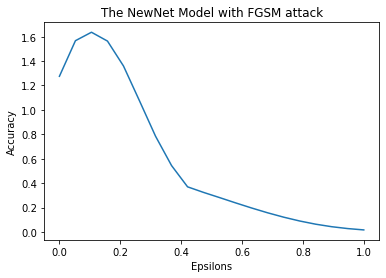

In [35]:
fig, ax = plt.subplots()
ax.plot(epsilon, density)
ax.set_xlabel("Epsilons")
ax.set_ylabel("Accuracy")
ax.set_title("The NewNet Model with FGSM attack")

In [34]:
print("Coverage")
print(f"Model_dataset & validation set: coverage: {coverage_validate}")
print(f"Model_dataset & adversarial samples")
for i in range(len(epsilon)):
    print("Epsilon: {:.5f}, Accuracy: {:.2f}%, Model_adv_coverage: {:.5f}, Vali_adv_coverage: {:.5f}".format(epsilon[i], robust_accuracy[i], coverage[i], vali_cov[i]))

Coverage
Model_dataset & validation set: coverage: 0.39364999532699585
Model_dataset & adversarial samples
Epsilon: 0.00000, Accuracy: 0.99%, Model_adv_coverage: 1.00000, Vali_adv_coverage: 1.00000
Epsilon: 0.05263, Accuracy: 0.99%, Model_adv_coverage: 1.00000, Vali_adv_coverage: 1.00000
Epsilon: 0.10526, Accuracy: 0.99%, Model_adv_coverage: 1.00000, Vali_adv_coverage: 1.00000
Epsilon: 0.15789, Accuracy: 0.99%, Model_adv_coverage: 1.00000, Vali_adv_coverage: 1.00000
Epsilon: 0.21053, Accuracy: 0.99%, Model_adv_coverage: 0.98890, Vali_adv_coverage: 0.98890
Epsilon: 0.26316, Accuracy: 0.99%, Model_adv_coverage: 0.94545, Vali_adv_coverage: 0.94545
Epsilon: 0.31579, Accuracy: 0.99%, Model_adv_coverage: 0.91480, Vali_adv_coverage: 0.91480
Epsilon: 0.36842, Accuracy: 0.99%, Model_adv_coverage: 0.89925, Vali_adv_coverage: 0.89925
Epsilon: 0.42105, Accuracy: 0.99%, Model_adv_coverage: 0.88475, Vali_adv_coverage: 0.88475
Epsilon: 0.47368, Accuracy: 0.98%, Model_adv_coverage: 0.87070, Vali_adv_c

## Attack the model using 20 epsilon & ```Boundary attack```

#### Attack the model using ```model_dataset```

In [42]:
#adv_bdy_images, adv_bdy_info = model_attack(attack1, original_model, images[:10,:,:,:], labels[:10], 0.4)

Plot the results

In [ ]:
fig, ax = plt.subplots()
robust_accuracy = []
for i in range(20):
    acc = 1 - adv_info[i, :].raw.cpu().numpy().astype(np.float32).mean(axis=-1)
    robust_accuracy.append(acc)
ax.plot(epsilon, robust_accuracy)
ax.set_xlabel("Epsilons")
ax.set_ylabel("Accuracy")
ax.set_title("The NewNet Model with Boundary attack")

In [ ]:
Form the images & labels from the validation set

In [179]:
images = []; labels=[]
for i in range(len(validation_set)):
    x, y = validation_set[i]
    images.append(x); labels.append(y)
#images = torch.stack(images).to(device)
#print(images.is_cuda())
torch.save(torch.stack(images).view(len(validation_set), -1), 'real_vali_images.pt')

In [165]:
# move tensors to the device and convert to ep tensors
images = ep.astensor(torch.stack(images).to(device))
labels = ep.astensor(torch.stack(labels).to(device))
images.shape, labels.shape

(torch.Size([2100, 1, 28, 28]), torch.Size([2100]))

In [146]:
#image, label = ep.astensors(*samples(fmodel_1, dataset='mnist', batchsize=1024))
#image.shape, label.shape

(torch.Size([1024, 1, 28, 28]), torch.Size([1024]))

Save the real images to file: real_images.pt

In [55]:
torch.save(image.raw.view(image.shape[0], -1), "real_images.pt")

## Attack the model with the choice of an attack

In [169]:
raw_adv, clip_adv, adv_ = attack0(fmodel_1, images, labels, epsilons=epsilon)

In [33]:
torch_arr = []
for i in range(len(clip_adv)):
    torch_arr.append(clip_adv[i].raw.view(clip_adv[i].shape[0], -1))
torch_arr = np.array(torch_arr)
np.save("adv_samples_new.npy", torch_arr)

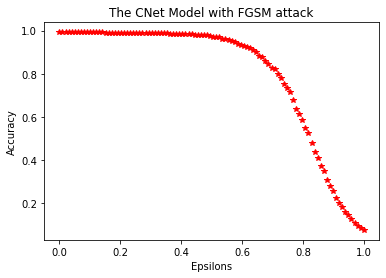

In [174]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for i in range(100):
    robust_accuracy = 1 - adv_[i, :].raw.cpu().numpy().astype(np.float32).mean(axis=-1)
    ax.plot(epsilon[i], robust_accuracy, 'r*')
    ax.set_xlabel("Epsilons")
    ax.set_ylabel("Accuracy")
    ax.set_title("The NewNet Model with FGSM attack")
    #ax.legend()


Plot the results:

In [115]:
#import matplotlib.pyplot as plt
#fig, ax = plt.subplots()
#for success, labels in zip(succes_rates_1, batches):
#    robust_accuracy = 1 - success.cpu().numpy().astype(np.float32).mean(axis=-1)
#    ax.plot(epsilon, robust_accuracy, label=labels)
#    ax.set_xlabel("Epsilons")
#    ax.set_ylabel("Accuracy")
#    ax.set_title("The CNet Model with FGSM attack")
#    ax.legend()
#plt.savefig("CNet_FGSM_attack.png")

In [29]:
succes_rates_1 = []
succes_rates_2 = []

for attacking in attack:
    raw, clipped, is_adv_1 = attacking(fmodel_1, images_1, labels_1, epsilons=epsilon)
    raw1, clipped1, is_adv_2 = attacking(fmodel_2, images_2, labels_2, epsilons=epsilon)
    succes_rates_1.append(is_adv_1)
    succes_rates_2.append(is_adv_2)


In [116]:
#import matplotlib.pyplot as plt
#fig, ax = plt.subplots()
#label = ['LinfPGD', 'Boundary_Attack', 'FGSM']
#for success, labels in zip(succes_rates_1, label):
#    robust_accuracy = 1 - success.cpu().numpy().astype(np.float32).mean(axis=-1)
#    ax.plot(epsilon, robust_accuracy, label=labels)
#    ax.set_xlabel("Epsilons")
#    ax.set_ylabel("Accuracy")
#    ax.set_title("The NewNet Model")
#    ax.legend()   

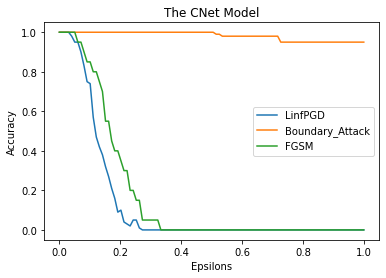

In [31]:
for success, labels in zip(succes_rates_2, label):
    robust_accuracy = 1 - success.cpu().numpy().astype(np.float32).mean(axis=-1)
    plt.plot(epsilon, robust_accuracy, label=labels)
    plt.xlabel("Epsilons")
    plt.ylabel("Accuracy")
    plt.title("The CNet Model")
    plt.legend()   
plt.show()

## Analysis on NewNet model after attack
- adv_samples.npy - the adversarial samples for epsilons ranging from 0 - 1 , 100 values
- real_images.pt - the real images as torch tensors

In [56]:
gen = np.load("adv_samples_new.npy", allow_pickle=True)
real = torch.load("real_images.pt", map_location='cpu')

Plot a real & adversarial sample

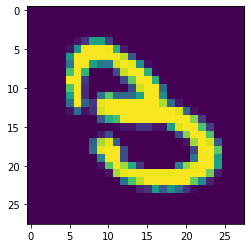

In [109]:
plt.imshow(real.numpy().reshape(real.shape[0], 28, 28)[798,:,:])

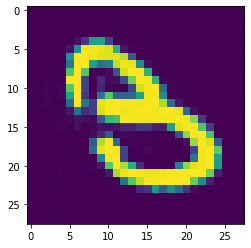

In [111]:
plt.imshow(gen[34].cpu().numpy().reshape(real.shape[0], 28, 28)[798,:,:])

In [114]:
#np.where(adv_.raw.cpu().numpy()[65, :]==True)[0]
print(adv_[34, 798])
print("epsilon value: ",epsilon[34])

PyTorchTensor(tensor(True, device='cuda:0'))
epsilon value:  0.3434343434343435


- Check the density & coverage between the adv samples and real samples

In [57]:
from n2gem import metrics

In [58]:
den = []
for i in range(3):
    density_value = metrics.gem_build_density(real, real.shape[0], gen[i].cpu(), 'indexflatl2', nk=3)
    den.append(density_value)
#coverage_value = metrics.gem_build_coverage(real, real.shape[0], gen[i].cpu(), 'indexflatl2', nk=3)
print(den)

The tree is created on the dataset of shape torch.Size([1024, 784]) using cuda
Creating the tree by indexflatl2 took 0.00125 sec
The tree is created on the dataset of shape torch.Size([1024, 784]) using cuda
Creating the tree by indexflatl2 took 0.00124 sec
The tree is created on the dataset of shape torch.Size([1024, 784]) using cuda
Creating the tree by indexflatl2 took 0.00130 sec
[tensor(5.1136), tensor(0.5413), tensor(0.)]


In [59]:
from sklearn.manifold import TSNE

In [60]:
x1 = real.cpu().numpy()
x2 = gen[0].cpu().numpy()

In [65]:
x1 = (x1 - np.min(x1))/(np.max(x1) - np.min(x1))

In [66]:
real_x = TSNE(n_components=2).fit_transform(x1)
gen_x = TSNE(n_components=2).fit_transform(x2)